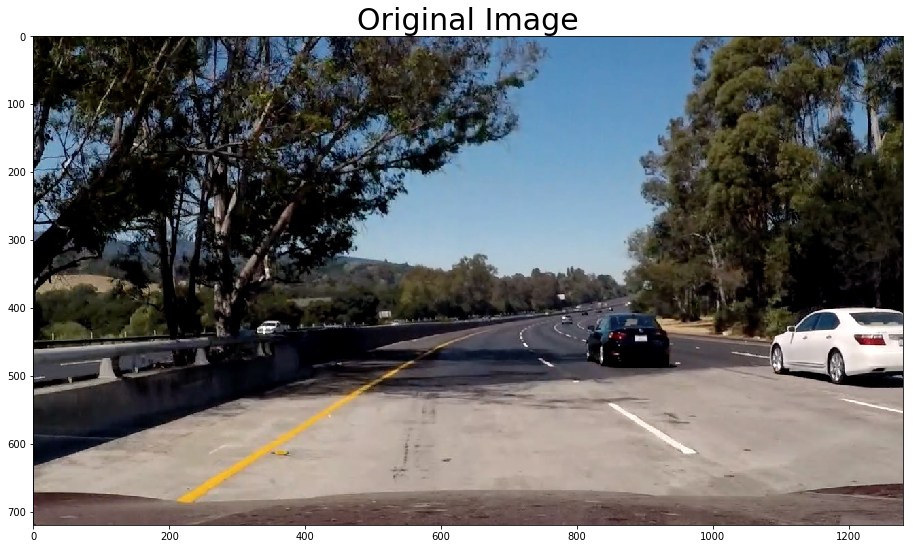

In [1]:
import pickle
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


serialize = pickle.load( open( "calibrate_matrix.pickle", "rb" ) )
mtx = serialize["mtx"]
dist = serialize["dist"]

# Check for calibration
# Compare the images post undistort
img_BGR = cv2.imread('test_images/test5.jpg')
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

# Show Single Image
def show_img(img, title, isGray=False, patch = None):
    f, ax = plt.subplots(1, 1, figsize=(24, 9))
    # Check if gray scale
    if isGray:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
    # Check if patch is there
    if patch is not None:
        ax.add_patch(rect)
    plt.title(title, fontsize=30)

show_img(img_RGB, 'Original Image')

In [2]:
# Perspective Transform using straight lines
import matplotlib.patches as patches
    
img_st_BGR = cv2.imread('test_images/straight_lines1.jpg')
img_st_RGB = cv2.cvtColor(img_st_BGR, cv2.COLOR_BGR2RGB)

# Create a mask remove side noise
def apply_transform_mask(_img , offset=100):
    _img[:,1:offset] = 0
    _img[:,_img.shape[1]-offset:_img.shape[1]] = 0
    return _img

# Undistort image 
def undistort(img, mask = True):    
    return cv2.undistort(img, mtx, dist, None, mtx)
    
# Create birds eye view from undistorted image
def birds_perspective(img, SPEED = 0):    
    # Define source points
    src = np.zeros((4, 2), dtype=np.float32)
    
    if SPEED == 0: # High speed - longer view
        # Long
        src[0] = [610,440]
        src[1] = [670,440]
        src[2] = [1130,720]
        src[3] = [190,720]
    elif SPEED == 1:
        # Medium
#         src[0] = [580,460]
#         src[1] = [705,460]
#         src[2] = [1130,720]
#         src[3] = [190,720]
        src[0] = [560,460]
        src[1] = [720,460]
        src[2] = [1230,720]
        src[3] = [50,720]
    elif SPEED == 2:      
        #Short
        src[0] = [480,500]
        src[1] = [800,500]
        src[2] = [1230,720]
        src[3] = [50,720]
    
    # Destination Points
    dst = np.zeros((4, 2), dtype=np.float32)
    width = img.shape[1]
    height = img.shape[0]
    offset1 = 250 # offset for dst points
    offset2 = 150
    dst[0] = (offset1, 0)
    dst[1] = (width-offset1, 0)
    dst[2] = (width-offset1, height)
    dst[3] = (offset1, height)
    
    M = cv2.getPerspectiveTransform(src, dst)
    dest_img = cv2.warpPerspective(img, M, (width, height),flags=cv2.INTER_LINEAR)
    
    return src, dst, M, dest_img



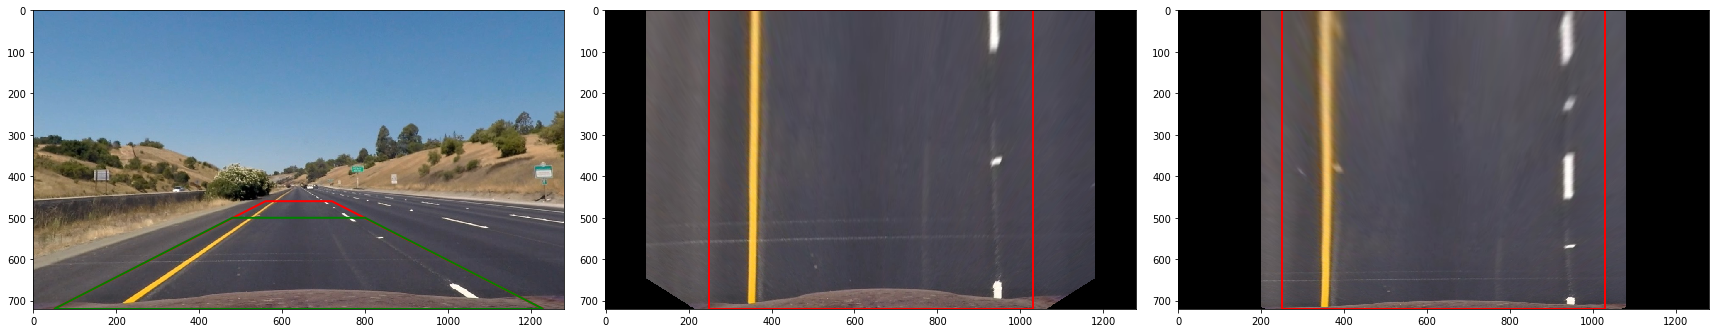

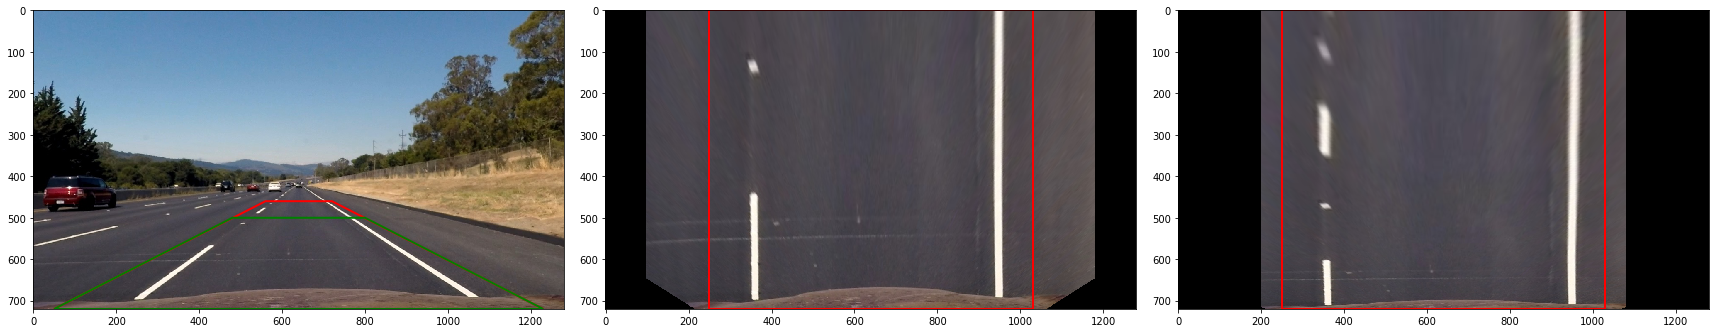

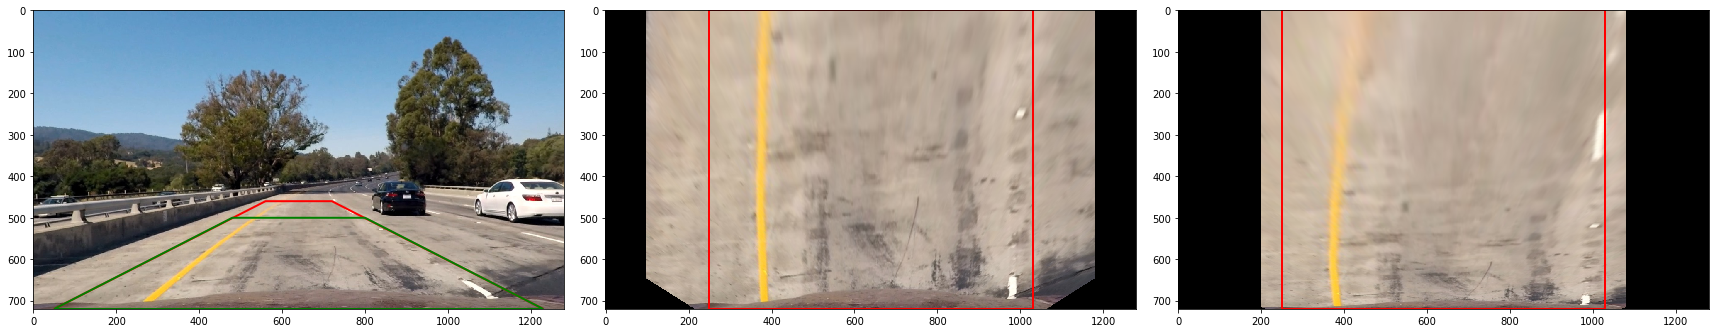

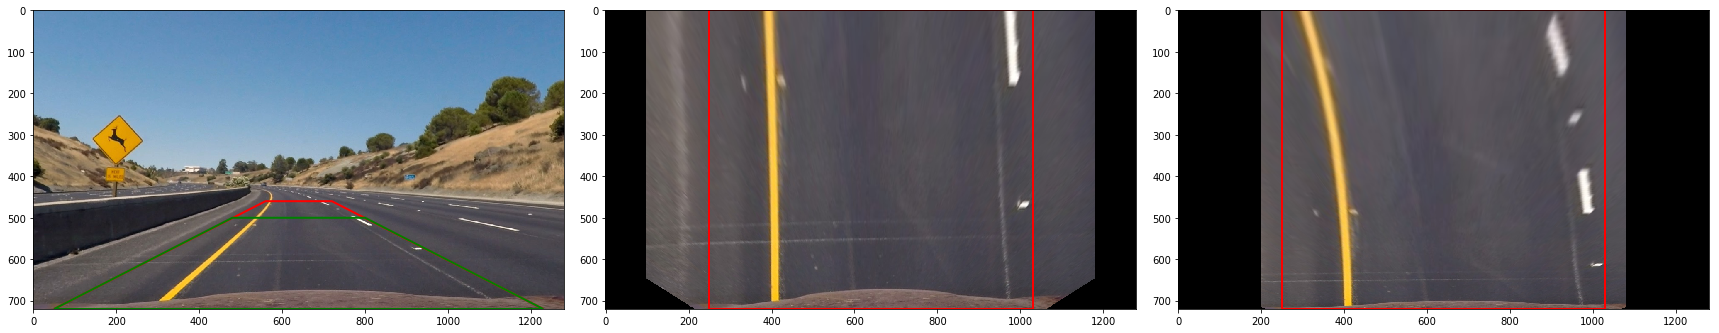

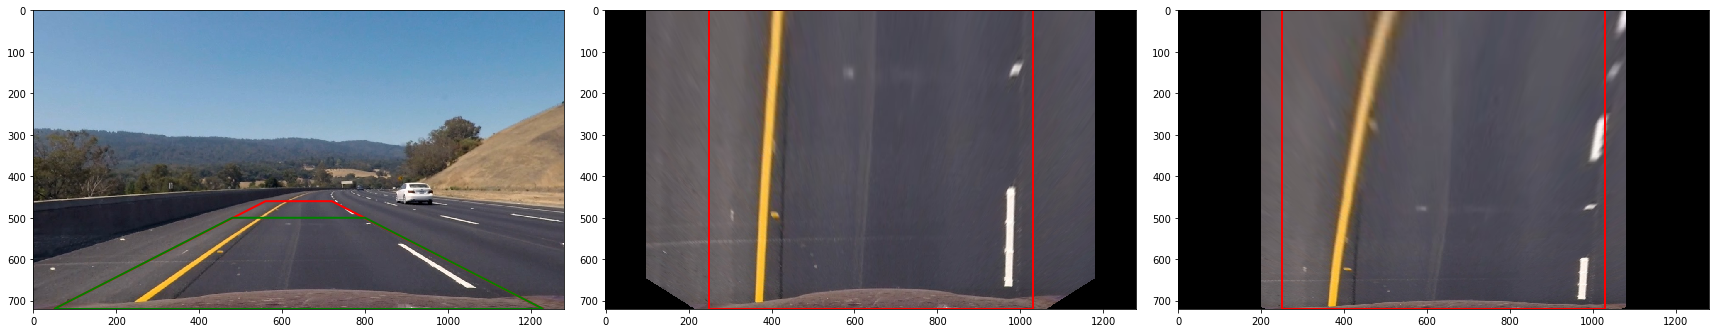

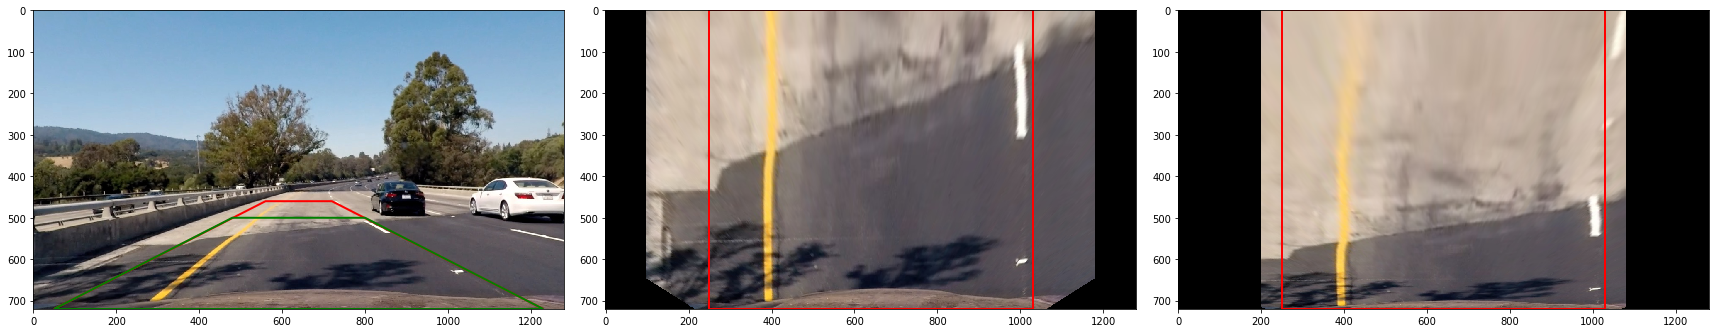

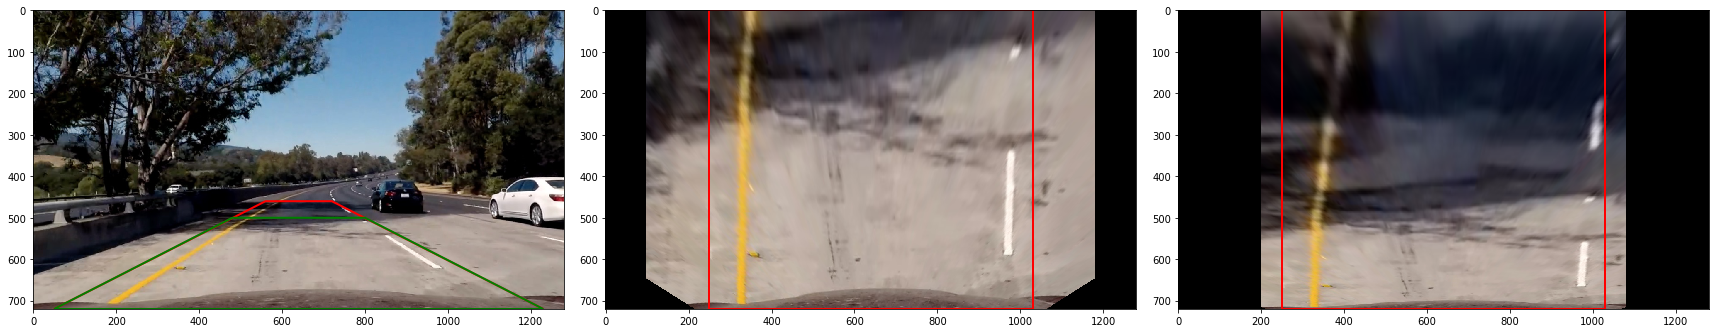

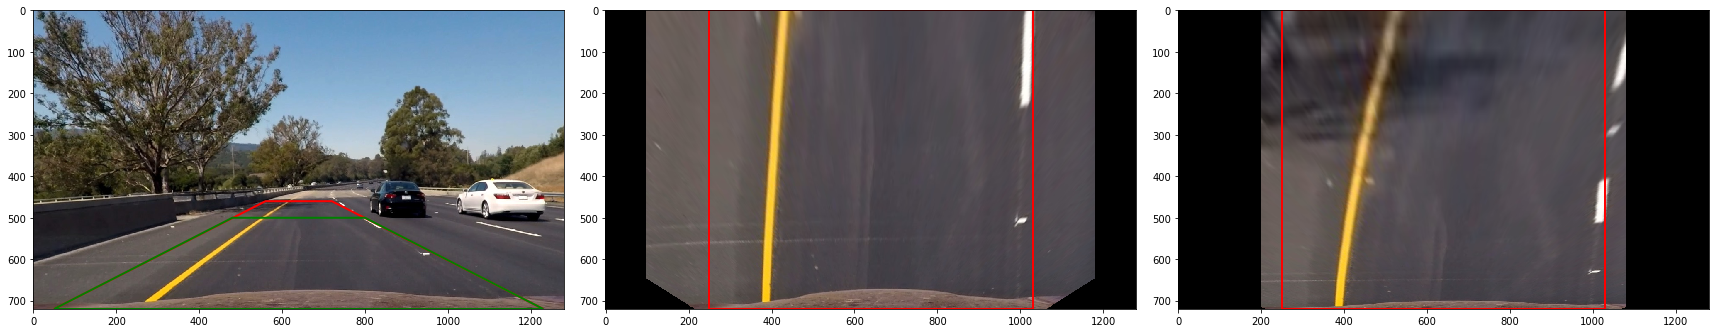

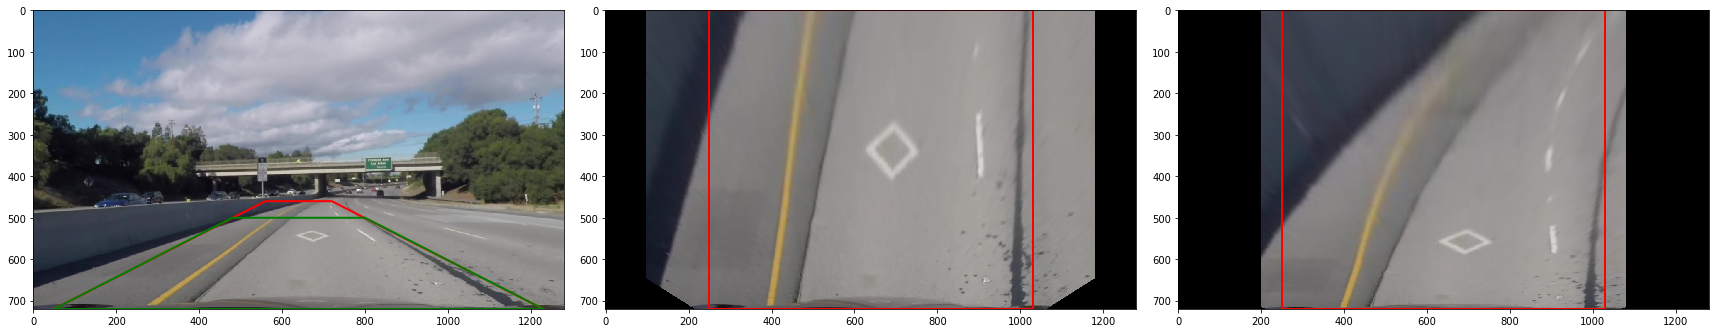

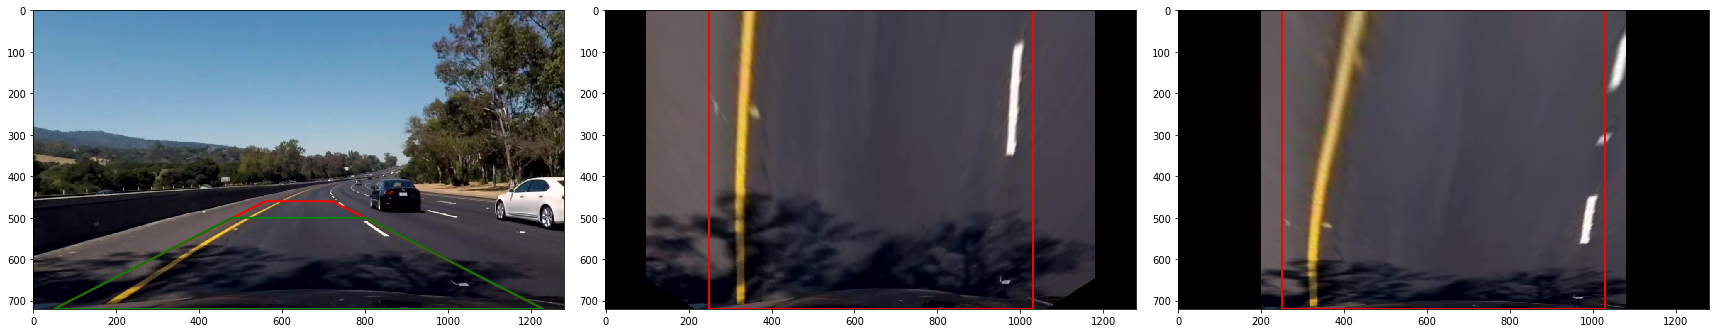

In [3]:
# Check long term lines
import glob
images = glob.glob('test_images/straight_lines*.jpg')
curved_images = glob.glob('test_images/test*.jpg')
images.extend(curved_images)
# Validate the perspective transform source for straight lines
for image in images:
    img = undistort(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB))
    src, dst, M, birds_eyeL = birds_perspective(img, 1)
    srcS, dstS, M, birds_eyeS = birds_perspective(img, 2)
    birds_eyeL = apply_transform_mask(birds_eyeL, 200)
    birds_eyeS = apply_transform_mask(birds_eyeS, 100)
    
    srcL = patches.Polygon( src, closed=True,linewidth=2,edgecolor='r',facecolor='none')
    srcS = patches.Polygon( srcS, closed=True,linewidth=2,edgecolor='g',facecolor='none')
    dstL = patches.Polygon( dst, closed=True,linewidth=2,edgecolor='r',facecolor='none')
    dstS = patches.Polygon( dstS, closed=True,linewidth=2,edgecolor='r',facecolor='none')
    f, (ax1, ax2, ax4) = plt.subplots(1,3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.add_patch(srcL)
    ax1.add_patch(srcS)
    ax2.imshow(birds_eyeS)
    ax2.add_patch(dstS)
    ax4.imshow(birds_eyeL)
    ax4.add_patch(dstL)


In [4]:
# Perform all operations on the birds eye view

# Apply generic threshold for high value targets
def apply_threshold_channel(_img_channel, thresh=(175, 255)):
    binary = np.zeros_like(_img_channel)
    binary[(_img_channel > thresh[0]) & (_img_channel <= thresh[1])] = 1
    return binary 

# Show all channels for a given color space
def show_channels(_img, space_name):
    f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(18, 4))
    f.tight_layout()
    ax0.imshow(_img)
    ax0.set_title('Original', fontsize=20)
    ax1.imshow(apply_threshold_channel(_img[:,:,0]), cmap='gray')
    ax1.set_title('Channel 1:' + space_name, fontsize=20)
    ax2.imshow(apply_threshold_channel(_img[:,:,1]), cmap='gray')
    ax2.set_title('Channel 2:' + space_name, fontsize=20)
    ax3.imshow(apply_threshold_channel(_img[:,:,2]), cmap='gray')
    ax3.set_title('Channel 3: '+ space_name, fontsize=20)

# Look at all spaces-channels for a given RGB image    
def explore_color_space(_img_RGB, show=False, distance=1):
    img_RGB = undistort(_img_RGB)    
    src, dst, M, bird_RGB = birds_perspective(img_RGB, distance)
    # Spaces - recommendation from https://github.com/JustinHeaton/Advanced-Lane-Finding/blob/master/Lane_Finding.ipynb
    HLS = cv2.cvtColor(bird_RGB, cv2.COLOR_RGB2HLS)
    LUV = cv2.cvtColor(bird_RGB, cv2.COLOR_RGB2LUV)
    LAB = cv2.cvtColor(bird_RGB, cv2.COLOR_RGB2Lab)
    # Explore Channels
    if show:
        show_channels(bird_RGB, 'RGB')
        show_channels(HLS, 'HLS')
        show_channels(LUV, 'LUV')
        show_channels(LAB, 'LAB')
    
    return bird_RGB, HLS, LUV, LAB, src, dst, M

# Reference straight line and complex lit image
# curved_images = glob.glob('test_images/test*.jpg')
# for image in curved_images:
#     explore_color_space(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB) , True)    



Some observations from above:
1. RGB Space: 
2. HLS Space: The S channel has very good definition
3. LUV and LAB: The L channels have similar definition as the R channel. The B channel is a revelation in the complex image. 

Final selection for Sobel
1. S and B channels as is
2. Have to evaluate Sobel using R, Gray and L from LUV

In [5]:
# Define all the Sobel functions

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = img
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sxbinary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = img
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    sobelxy = np.sqrt(np.square(sobelx)+ np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobelxy/np.max(sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = img
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(np.square(sobelx))
    abs_sobely = np.sqrt(np.square(sobely))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    #sobelxy = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    sobelxy = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(sobelxy)
    sxbinary[(sobelxy >= thresh[0]) & (sobelxy <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

In [6]:
# Explore/Evaluate Thresholds for Given Channels
dir_thres = (.1, .4)

def explore_sobel(_img, ksize=3):
    gradx = abs_sobel_thresh(_img, orient='x', sobel_kernel=5, thresh=(20, 100))
    mag_binary = mag_thresh(_img, sobel_kernel=ksize, mag_thresh=(20, 255))
    return gradx, mag_binary

def print_sobel_outputs(_img_RGB, gradx, mag_binary, text):
    f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 4))
    f.tight_layout()
    ax0.imshow(_img_RGB)
    ax0.set_title('Original-' + text, fontsize=20)
    ax1.imshow(gradx, cmap='gray')
    ax1.set_title('GradX-'+ text, fontsize=20)
    ax2.imshow(mag_binary, cmap='gray')
    ax2.set_title('Mag-'+ text, fontsize=20)
    

def evaluate_sobel(_img_RGB):
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements
    offset = 200
    RGB, HLS, LUV, LAB, src, dst, M = explore_color_space(_img_RGB, False, 1)
    gradx, mag_binary = explore_sobel(RGB[:,:,0], ksize)
    print_sobel_outputs(RGB, apply_transform_mask(gradx , offset), apply_transform_mask(mag_binary , offset), 'R' )
    
    gradx, mag_binary = explore_sobel(cv2.cvtColor(RGB, cv2.COLOR_RGB2GRAY), ksize)
    print_sobel_outputs(RGB, apply_transform_mask(gradx , offset), apply_transform_mask(mag_binary , offset) ,'Gray')
    
    gradx, mag_binary = explore_sobel(LUV[:,:,0], ksize)
    print_sobel_outputs(RGB, apply_transform_mask(gradx , offset), apply_transform_mask(mag_binary , offset) ,'L')

# curved_images = glob.glob('test_images/test*.jpg')
# for image in curved_images:
#     _img_RGB = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)   
#     evaluate_sobel(_img_RGB)   

Here we select the following thresholding functions:
1. R Channel with Grad X


In [7]:
# Thresholding function based on work above
def combined_threshold_mask(_img_RGB, show = False, distance=1):
    ksize = 3
    RGB, HLS, LUV, LAB, src, dst, M  = explore_color_space(_img_RGB, False, distance)
    
    # Final Selections - See rationale above
    R_gradx = abs_sobel_thresh(RGB[:,:,0], orient='x', sobel_kernel=5, thresh=(20, 100)) 
    B = apply_threshold_channel(LAB[:,:,2])
    S = apply_threshold_channel(HLS[:,:,2])
    
                                       
    #Combine
    combined = np.zeros_like(R_gradx)
    # Color stack
    color_binary = np.dstack((R_gradx, B, S)) * 255
    # Combined 
    combined[(R_gradx ==1) | (B == 1) | (S == 1) ] = 1 # (R_gradx == 1) | 
    
    #Apply mask 
    combined = apply_transform_mask(combined, 200)
    color_binary = apply_transform_mask(color_binary, 200)
    
    if show:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(RGB)
        ax1.set_title('Birds EyeView', fontsize=20)
        ax3.imshow(color_binary)
        ax3.set_title('Color binary', fontsize=20)
        ax2.imshow(combined, cmap='gray')
        ax2.set_title('Combined', fontsize=20)
        
    
    return color_binary, combined, RGB,  src, dst, M 
    
# Test all images   
# curved_images = glob.glob('test_images/*.jpg')
# for image in curved_images:
#     combined_threshold_mask(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB), True)
    

In [28]:
# Finding lane pixels - from Course material. If you dont know anything about the frame
def find_lane_pixels_no_history(binary_warped):
    # Find confidence of the curve you are providing
    confidence_left = 0
    confidence_right = 0
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Find the offset over center_point_windows windows (immediately infront of the car)
    left_point = 0
    right_point = 0
    center_point_windows = 2
    

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    # Window width exapand to eventually cover atleast half the window
    l_margin = 100
    r_margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        # Ideally there should be a check to ensure that this window does not cross half way points, low and high
        win_xleft_low = (leftx_current - l_margin) if  (leftx_current - l_margin)> 0 else 0 # Update this
        win_xleft_high = (leftx_current + l_margin) if (leftx_current + l_margin) < binary_warped.shape[1]//2 else binary_warped.shape[1]//2  # Update this
        win_xright_low = (rightx_current - r_margin) if (rightx_current - r_margin) > binary_warped.shape[1]//2 else binary_warped.shape[1]//2   # Update this
        win_xright_high = (rightx_current + r_margin) if (rightx_current + r_margin) < binary_warped.shape[1] else binary_warped.shape[1]  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(255,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        #print(left_lane_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        #print (left_lane_inds)
        if len(good_left_inds) > minpix*3:
            # Increase confidence and reduce window margin to default
            confidence_left += 1
            l_margin = 100
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))    
        else:
            l_margin = int(1.25* l_margin)
        if len(good_right_inds) > minpix*3:        
            # Increase confidence and reduce window margin to default
            confidence_right += 1
            r_margin = 100
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        else:
            #Lets increase window margin width by 25% (incase lane is turning)
            r_margin = int(1.25* r_margin)
            
        # For few windows consider offset
        if(window < center_point_windows):
            # Add left_center point
            left_point += leftx_current
            # Add left_center point
            right_point += rightx_current
        

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #Computer center point
    center_point = (left_point/center_point_windows + right_point/center_point_windows)//2

    return leftx, lefty, rightx, righty, out_img, confidence_left, confidence_right, center_point

In [29]:
# Finding Polynomial Fit
def fit_polynomial(leftx, lefty, rightx, righty, out_img):
   
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, birds_eyeL.shape[0]-1, birds_eyeL.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [255, 0, 0]

    return left_fitx, right_fitx, out_img, left_fit, right_fit

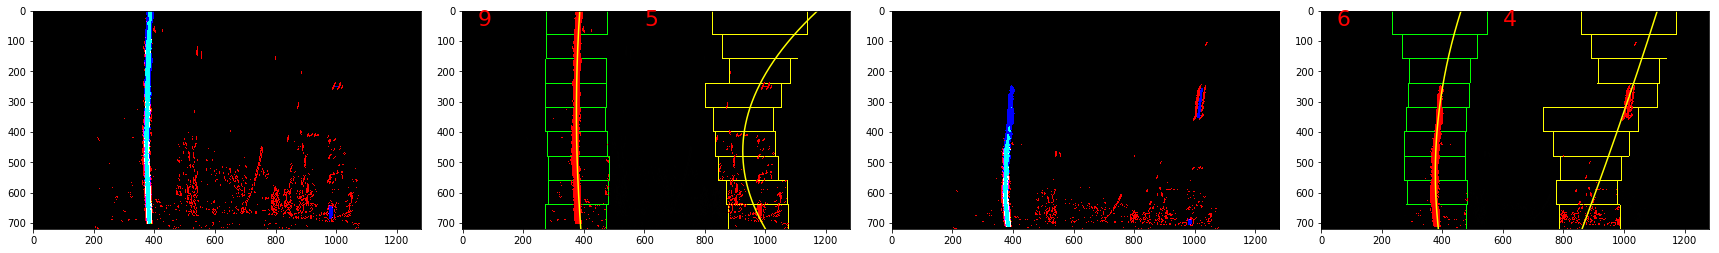

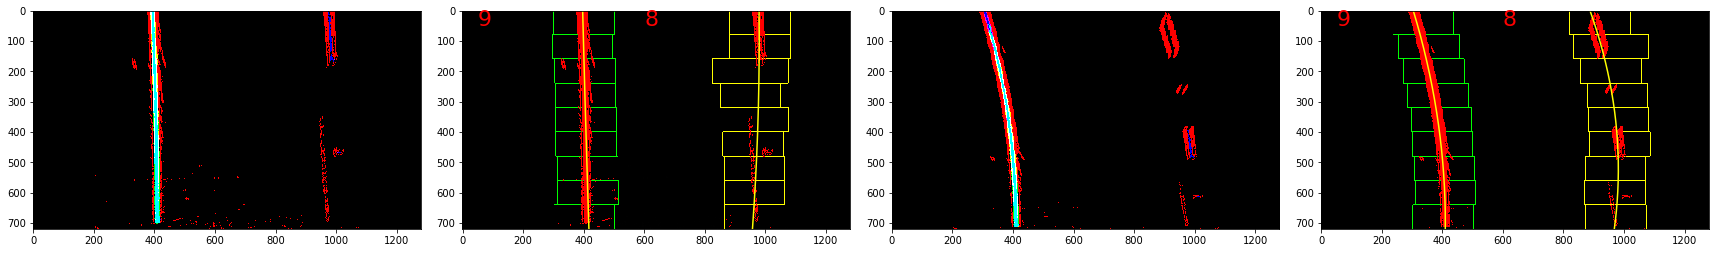

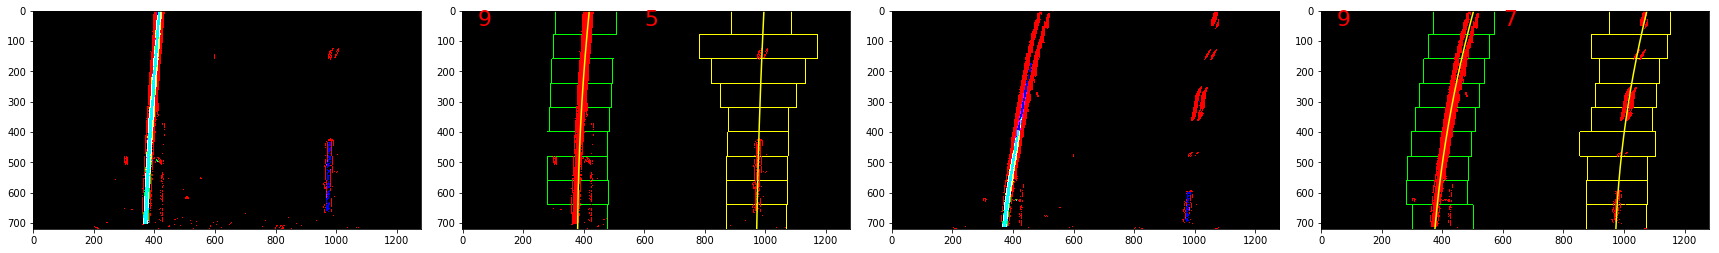

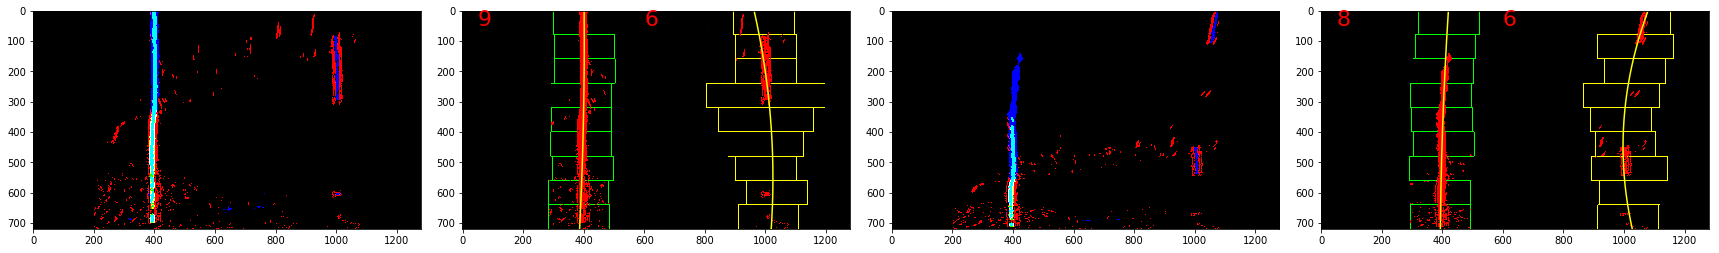

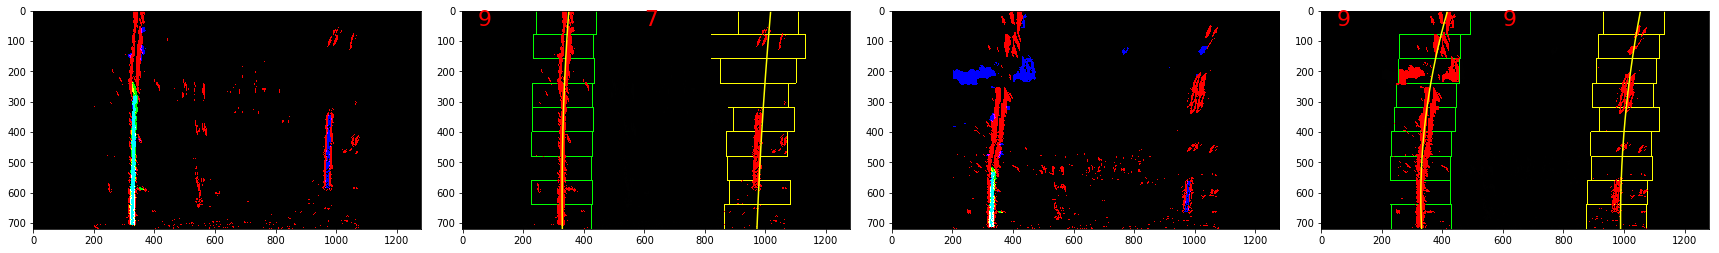

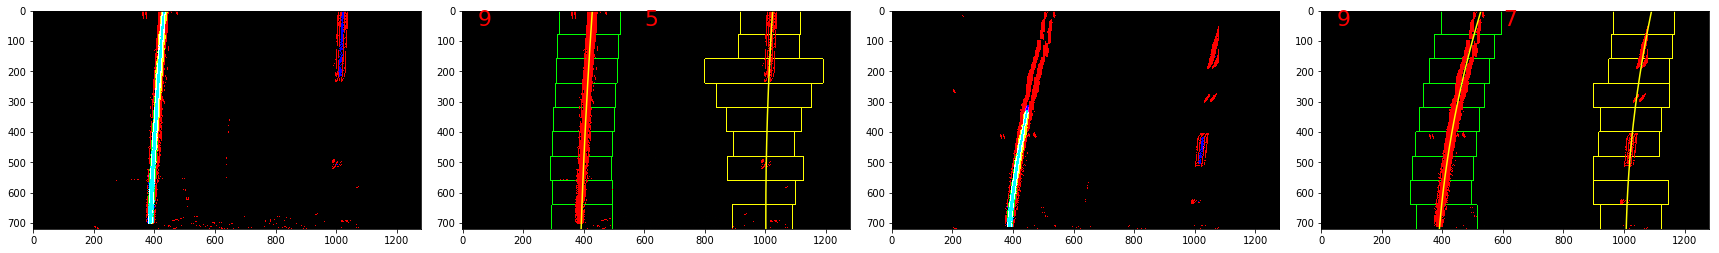

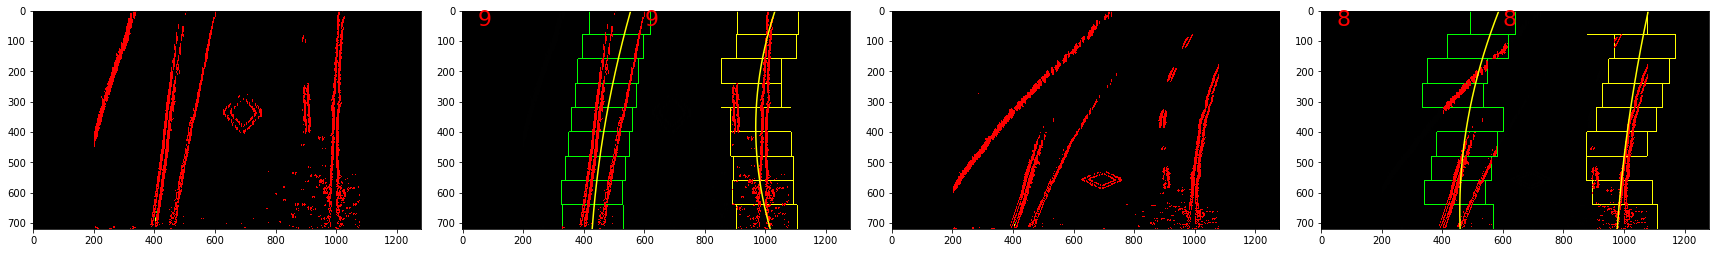

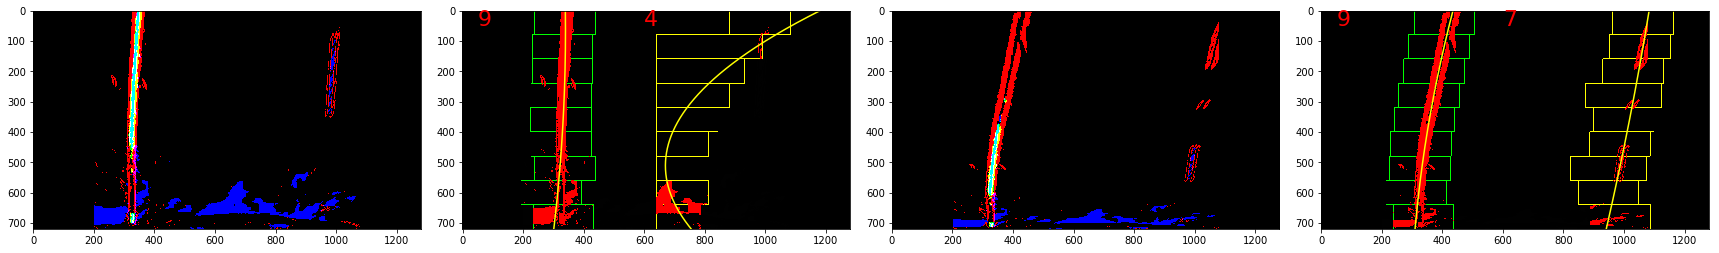

In [30]:
# Plot and get measure of road to pixel info
images = glob.glob('test_images/test*.jpg')

px1=50
py1=50
px2=600
py2=50

for image in images:
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    color_binary, combined, RGB, src, dst, M = combined_threshold_mask(img, False, 2)
    color_binary1, combined1, RGB1, src, dst, M = combined_threshold_mask(img, False, 1)
    #src, dstL, M, birds_eyeL = birds_perspective(combined, 0)
#     src, dstM, M, birds_eyeM = birds_perspective(combined, 1)
#     src, dstS, M, birds_eyeS = birds_perspective(combined, 2)
    
    # Show the original picture
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 9))
    f.tight_layout()
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, birds_eyeL.shape[0]-1, birds_eyeL.shape[0] )
    
    # Find lanes, pixels
    leftx, lefty, rightx, righty, out_imgS, confidence_left, confidence_right, center_point = find_lane_pixels_no_history(combined)
    left_fitx, right_fitx, out_imgS, left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty, out_imgS)
    ax1.imshow(color_binary)
    ax2.imshow(out_imgS, cmap='gray')
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    ax2.text(px1, py1, confidence_left , fontsize=22,color='r')
    ax2.text(px2, py2, confidence_right , fontsize=22,color='r')
    
    ax3.imshow(color_binary1)
    leftx, lefty, rightx, righty, out_imgM, confidence_left, confidence_right, center_point = find_lane_pixels_no_history(combined1)
    left_fitx, right_fitx, out_imgM, left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty, out_imgM)
    ax4.imshow(out_imgM, cmap='gray')
    ax4.plot(left_fitx, ploty, color='yellow')
    ax4.plot(right_fitx, ploty, color='yellow')
    ax4.text(px1, py1, confidence_left , fontsize=22,color='r')
    ax4.text(px2, py2, confidence_right , fontsize=22,color='r')
    
#     leftx, lefty, rightx, righty, out_imgL = find_lane_pixels_no_history(birds_eyeL)
#     left_fitx, right_fitx, out_imgL = fit_polynomial(leftx, lefty, rightx, righty, out_imgL)
#     ax4.imshow(out_imgL, cmap='gray')
#     ax4.plot(left_fitx, ploty, color='yellow')
#     ax4.plot(right_fitx, ploty, color='yellow')
  
    

In [31]:
# Searh from prior fit
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit  = fit_poly(leftx, lefty, rightx, righty, binary_warped)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

In [32]:
# Measure Curvature ym_per_pix varies based on short/med/long distances. xm_per_pix remains same
def measure_curvature_real(leftx, lefty, rightx, righty, left_fit_cr, right_fit_cr, y_max, ym_per_pix):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters    
    xm_per_pix = 3.7/571 # meters per pixel in x dimension
    
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*y_max + left_fit_cr[1])**2)**(3/2))/(2* (left_fit_cr[0]))  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit_cr[0]*y_max + right_fit_cr[1])**2)**(3/2))/(2* (right_fit_cr[0]))  ## Implement the calculation of the right line here
    #print('M: ', left_curverad, right_curverad)
    
    
    return int(round(left_curverad)), int(round(right_curverad))

In [33]:
# Find our lane pixels and fit polynomial
import random
images = glob.glob('test_images/*.jpg')

px1=50
py1=50
px2=550
py2=50

def find_lanes(_img, distance = 1, display = False, failure_log = False):
    color_binary, combined, RGB,  src, dst, M  = combined_threshold_mask(_img, False, distance)
    #Find lanes, pixels
    leftx, lefty, rightx, righty, out_imgS, confidence_left, confidence_right, center_point = find_lane_pixels_no_history(combined)
    left_fitx, right_fitx, out_imgS, left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty, out_imgS)
    #print(left_fit[0], left_fit[1], left_fit[2])
    ym_pixel = (3.0/110) if (distance == 1) else 3.0/201
    xm_per_pix = 3.7/571 
    offset_center = (center_point-_img.shape[1]//2) * xm_per_pix
    left_curverad, right_curverad = measure_curvature_real(leftx, lefty, rightx, righty, left_fitx, right_fitx, RGB.shape[0], ym_pixel)
    # Generate x and y values for plotting
    ploty = np.linspace(0, RGB.shape[0]-1, RGB.shape[0] )
    
    if display:
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
        f.tight_layout() 
        ax1.imshow(RGB)        
        ax2.imshow(out_imgS, cmap='gray')
        # Set linestyle type 
        linestyle_l = '-' if confidence_left >= 6 else '--'
        linestyle_r = '-' if confidence_right >= 6 else '--'
        
        ax1.plot(left_fitx, ploty, color='green', linewidth=confidence_left, linestyle=linestyle_l)
        ax1.plot(right_fitx, ploty, color='green',linewidth=confidence_right, linestyle=linestyle_r)

        ax2.plot(left_fitx, ploty, color='yellow', linewidth=confidence_left, linestyle=linestyle_l)
        ax2.plot(right_fitx, ploty, color='yellow', linewidth=confidence_right, linestyle=linestyle_r)
        ax2.text(px1, py1, '{}({})'.format(left_curverad, confidence_left) , fontsize=22,color='r')
        ax2.text(px2, py2, '{}({})'.format(right_curverad,confidence_right) , fontsize=22,color='r')
        ax2.text(px2, 650, 'Offset = {0:.2f}m'.format(offset_center) , fontsize=22,color='r')
            
    
    return color_binary, combined, RGB,  src, dst, M, confidence_left, confidence_right, left_fit, right_fit, out_imgS, left_curverad, right_curverad, ploty, offset_center
    
# for image in images:
#     img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
#     find_lanes(img, distance = 1, display = True)
       


As can be see from the above examples, all the lanes findings are not perfect. However, there is a confidence measure on the prediction. The solid lines are having high confidence while the dashed lines not so much. 

In [40]:
# Define lines
# Define a class to receive the characteristics of each line detection
import collections

class Line():
    def __init__(self):
        self.fits = collections.deque(maxlen=20)
        self.rad = collections.deque(maxlen=20)
        
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    # Lane update
    def update_lane(self, confidence, fit, curvature):
        #If low confidence, ignore this result
        if confidence < 4 :
            return
        # Also validate curvature with other lane when confidence on other lane is high
#         if (confidence_other_lane > 7):
#             if not ((curvature < 1.2 * curvature_other_lane) and (curvature > 0.8 * curvature_other_lane)):
#                 return
        self.fits.append(fit)
        self.rad.append(curvature)
    
    # Get curvature
    def get_curvature(self):
        return np.mean(np.asarray(self.rad))
    
    # Get Polyline
    def get_poly(self):
        return np.mean(np.asarray(self.fits), axis=0)
    
    def clear(self):
        self.fits.clear()
        self.rad.clear()

# Tests
# ll = Line()
# ll.update_lane(7, [0.000297530827725, -0.391688738615, 586.72289665], 1)
# ll.update_lane(7, [0.000297530827725, -0.391688738615, 586.72289665], 2)
# ll.update_lane(7, [0.000297530827725, -0.391688738615, 586.72289665], 3)
# ll.update_lane(7, [0.000297530827725, -0.391688738615, 586.72289665], 4)
# ll.update_lane(7, [0.000297530827725, -0.391688738615, 586.72289665], 5)
# ll.update_lane(7, [0.000297530827725, -0.391688738615, 586.72289665], 5)

# print(ll.get_curvature())
# print(ll.get_poly())

In [41]:
# Project it back on the image
from matplotlib import pyplot
px1=50
py1=50
px2=50
py2=100
px3=650
py3=100


ll = Line()
rl = Line()

def process_images(_img, distance = 1, display = False):
    color_binary, combined, RGB,  src, dst, M, confidence_left, confidence_right, left_fit, right_fit,  out_imgS, left_curverad, right_curverad, ploty, offset_center = find_lanes(_img, distance, False)
    ll.update_lane(confidence_left, left_fit, left_curverad)
    rl.update_lane(confidence_right, right_fit, right_curverad)

    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fit = ll.get_poly()
    right_fit = rl.get_poly()
    
#     # experiments
#     right_fit = ll.get_poly()
#     right_fit[2] += 500
    
    # Get the new points based on averages
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(_img, 1, newwarp, 0.3, 0)
    
    # Add text to it
    font                   = cv2.FONT_HERSHEY_SIMPLEX    
    fontScale              = 1
    fontColor              = (0,255,255)
    lineType               = 2
    bottomLeftCornerOfText1 = (px1,py1)
    bottomLeftCornerOfText2 = (px2,py2)
    bottomLeftCornerOfText3 = (px3,py3)
    cv2.putText(result,'Radius is {}m'.format((ll.get_curvature() +rl.get_curvature())//2), bottomLeftCornerOfText1, font, fontScale, fontColor, lineType)
    cv2.putText(result,'Offset is {0:.2f}m'.format(offset_center), bottomLeftCornerOfText2, font, fontScale, fontColor, lineType)
    
    if display:
        f, (ax1,ax2,ax3,ax4)  = plt.subplots(1,4, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(_img)
        ax2.imshow(RGB)
        ax3.imshow(combined)
        ax4.imshow(result)
    
        
    if(confidence_left <4 or confidence_right <4):
        result_failure = result.copy()
        val = random.randint(1,100)
        filename = 'failed'+str(val)+'.jpg'
        filename2 = 'failed'+str(val)+ '_combined'+ '.jpg'
        cv2.putText(result_failure,'Confidence {},{}'.format(confidence_left, confidence_right), bottomLeftCornerOfText3, font, fontScale, fontColor, lineType)
        cv2.imwrite(filename, cv2.cvtColor(result_failure, cv2.COLOR_RGB2BGR))
        #cv2.imwrite(filename2, color_binary)
        pyplot.imsave(filename2, out_imgS)

    return result

# images = glob.glob('test_images/*.jpg')
# for image in images:
#     img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
#     process_images(img, 1, True)
  
    
    

In [43]:
# Try it on the video without any smoothning
from moviepy.editor import VideoFileClip

ll.clear()
rl.clear()

lanes_output = 'output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video2.mp4")#.subclip(41,43)
lanes_clip = clip1.fl_image(process_images) #NOTE: this function expects color images!!
lanes_clip.write_videofile(lanes_output, audio=False)

clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:10<00:00,  6.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



In [127]:
lanes_output = 'full_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
lanes_clip = clip1.fl_image(process_images) #NOTE: this function expects color images!!
lanes_clip.write_videofile(lanes_output, audio=False)

clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video full_output.mp4
[MoviePy] Writing video full_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:07<00:00,  6.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: full_output.mp4 



In [129]:
lanes_output = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4").subclip(0,2)
lanes_clip = clip1.fl_image(process_images) #NOTE: this function expects color images!!
lanes_clip.write_videofile(lanes_output, audio=False)

clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 



In [132]:
lanes_output = 'harder_challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,5)
lanes_clip = clip1.fl_image(process_images) #NOTE: this function expects color images!!
%time lanes_clip.write_videofile(lanes_output, audio=False)

clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4




  0%|                                                                                          | 0/126 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/126 [00:00<00:19,  6.34it/s]

  2%|█▎                                                                                | 2/126 [00:00<00:19,  6.44it/s]

  2%|█▉                                                                                | 3/126 [00:00<00:19,  6.28it/s]

  3%|██▌                                                                               | 4/126 [00:00<00:20,  6.05it/s]

  4%|███▎                                                                              | 5/126 [00:00<00:20,  6.00it/s]

  5%|███▉                                                                              | 6/126 [00:01<00:20,  5.95it/s]

  6%|████▌                                                                             | 7/126 [00:01<00:20,  5.85it/s]

  6%|█████▏                   

[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 21.7 s
